<a href="https://colab.research.google.com/github/sclaudiobr/algoritmos-py/blob/master/filtragem02.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Filtragem

As técnicas de filtragem são transformações da imagem pixel a pixel, que não dependem apenas do nível de cinza de um determinado pixel, mas também do valor dos níveis de cinza dos pixels vizinhos. O processo de filtragem é feito utilizando matrizes denominadas máscaras, as quais são aplicadas sobre a imagem. Um exemplo de mascara é apresentado através de matrizes (arrays) através da biblioteca numpy.

In [48]:
!pip install Pillow

In [0]:
from osgeo import ogr, gdal, osr
import numpy as np
import os
import matplotlib.pyplot as plt
import cv2
import PIL as pil
import scipy.signal
import matplotlib.pyplot as plt
from skimage import io, color
from skimage import exposure
import urllib.request

In [141]:

url = ('https://github.com/sclaudiobr/algoritmos-py/blob/master/camobi_201839_GEO.tar.xz?raw=true')
filename, headers = urllib.request.urlretrieve(url, filename="camobi_201839_GEO.tar.xz")
print ("download completo!")
print ("download Nome do arquivo: ", filename)
#print ("download headers: ", headers)

download completo!
download Nome do arquivo:  camobi_201839_GEO.tar.xz


In [142]:
print ("descompactando...")
!tar -Jxxvf camobi_201839_GEO.tar.xz

descompactando...
camobi_201839_GEO.tif


In [0]:
img = io.imread('camobi_201839_GEO.tif')   # Load the image/content/camobi_201839.tif
img = color.rgb2gray(img)       # Convert the image to grayscale (1 channel)
B5_GDAL = gdal.Open('camobi_201839_GEO.tif')
B5_ARRAY = B5_GDAL.GetRasterBand(1).ReadAsArray().astype(np.float32)
path_GDALB = 'FILTRADA.TIF'

# PEGANDO DADOS DE GEORREFERENCIAS DA IMAGEM 
# Processo necessário para reprojetar de volta a matriz obtida com os calculos
projection = B5_GDAL.GetProjection()
geotransform = B5_GDAL.GetGeoTransform()
originX,pixelWidth,empty,finalY,empty2,pixelHeight=geotransform
cols =  B5_GDAL.RasterXSize
rows =  B5_GDAL.RasterYSize
finalX = originX + pixelWidth * cols
originY = finalY + pixelHeight * rows
extentArray = [originX,finalX,originY,finalY]


# CRIANDO AS MARCARAS
#Filtros passa baixa
passa_baixa1 = np.array([[1,1,1],[1,2,1],[1,1,1]])/9 # 1/10
passa_baixa2 = np.array([[1,2,1],[2,4,2],[1,2,1]])/16 # 1/16
# Filtros ineares passa alta
passa_alta1 = np.array([[0,-1,0],[-1,5,-1],[0,-1,0]])
passa_alta2 = np.array([[-1,-1,-1],[-1,9,-1],[-1,-1,-1]])
passa_alta3 = np.array([[1,-2,1],[1,5,1],[1,-2,1]])
# Realce de bordas direcional
realce_dirN  = np.array([[1,1,1],[1,-2,1],[-1,-1,-1]]) # realce direcional Norte
realce_dirNE = np.array([[1,1,1],[-1,-2,1],[-1,-1,1]]) # realce direcional ordeste
realce_dirL  = np.array([[-1,1,1],[-1,-2,1],[-1,1,1]]) # realce direcional Leste
realce_dirSE = np.array([[-1,-1,1],[-1,-2,1],[1,1,1]]) # realce direcional Sudeste
realce_dirS  = np.array([[-1,-1,-1],[1,-2,1],[1,1,1]]) # realce direcional Sul
realce_dirSW = np.array([[1,-1,-1],[1,-2,-1],[1,1,1]]) # realce direcional Sudoeste
realce_dirW  = np.array([[1,1,-1],[1,-2,-1],[1,1,-1]]) # realce direcional Oeste
realce_dirNW = np.array([[1,1,1],[1,-2,-1],[1,-1,-1]]) # realce direcional Noroeste
# Realce não linear de bordas
realce_bordaA = np.array([[-1,-1,-1],[-1,8,-1],[-1,-1,-1]])
realce_bordaM = np.array([[ 0,-1, 0],[-1 , 4,-1],[0,-1,0]])
realce_bordaB = np.array([[ 1,-2, 1],[-2, 3,-2], [1,-2,1]])
# Realce não linear
realce_sobela = np.array([[-1,2,-1],[ 0,0,0],[ 1,2,1]])
realce_sobelb = np.array([[-1, 0,1],[-2,0,2],[-1,0,1]])
realce_sobel = np.array(np.sqrt(realce_sobela**2+realce_sobelb**2))
# Filtros morfológicos
realce_mediano = np.array([[1,1,1],[1,1,1],[1,1,1]])
realce_xis     = np.array([[1,0,1],[0,1,0],[1,0,1]])
realce_cruz    = np.array([[0,1,0],[1,1,1],[0,1,0]])
realce_hor     = np.array([[0,0,0],[1,1,1],[0,0,0]])
realce_vert    = np.array([[0,1,0],[0,1,0],[0,1,0]])
realce_diag1   = np.array([[0,0,1],[0,1,0],[1,0,0]])
realce_diag2   = np.array([[1,0,0],[0,1,0],[0,0,1]])

/usr/local/lib/python3.6/dist-packages/skimage/util/dtype.py:135: UserWarning: Possible precision loss when converting from float64 to uint16
  .format(dtypeobj_in, dtypeobj_out))


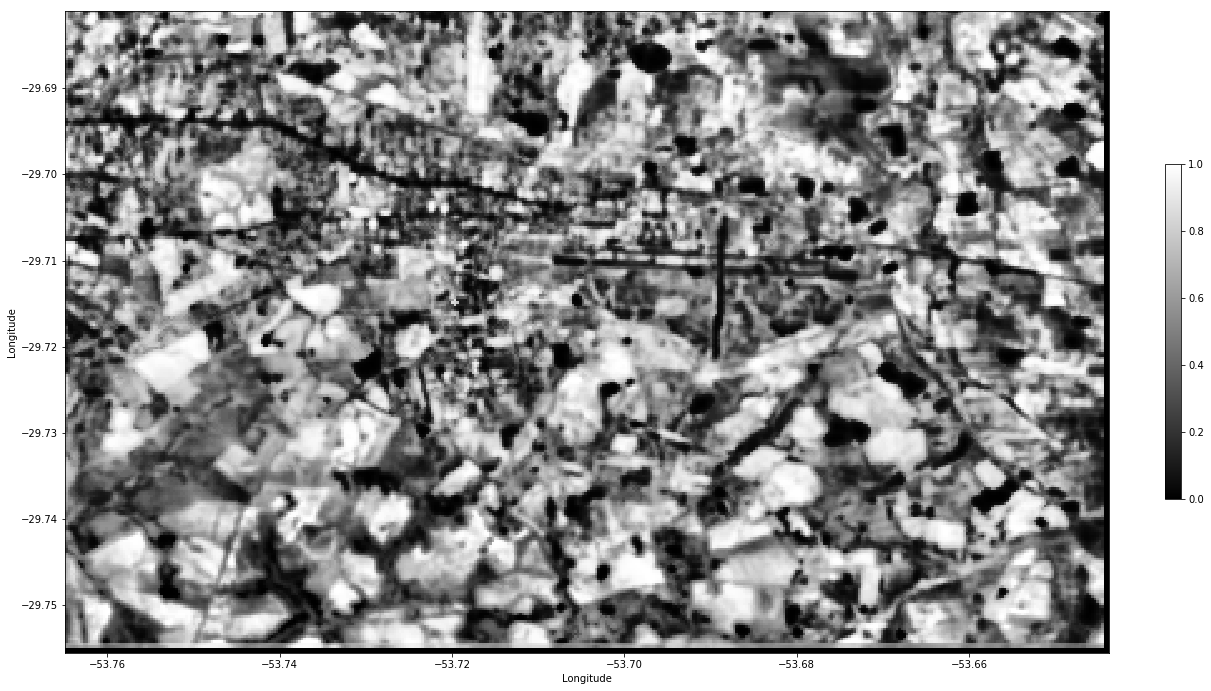

In [144]:
# O FILTRO É ALTERADO NA LINHA ABAIXO ---> realce = <AQUI>

realce = realce_cruz   # <-- AQUI coloque o nome de um dos filtros acima

# ---- FUNÇÔES

# Aplicação do realce com a máscara escolhida acima
def frealce(realce):
  filtro = scipy.signal.convolve2d(img, realce, 'valid') # <-- AQUI coloque o nome de um dos filtros acima
  return filtro
filtrada = frealce(realce)

# Ajuste do contraste da imagem filtrada com aplicação de uma Equalização de histograma
def equImage(filtrada):
  equalizada = exposure.equalize_adapthist(filtrada/np.max(np.abs(filtrada)), clip_limit=0.03)
  return equalizada

FILTRADA = equImage(filtrada)

# ----- Salvando os dados
def saveRaster(dataset,datasetPath,cols,rows,projection):
    rasterSet = gdal.GetDriverByName('GTiff').Create(datasetPath, cols, rows,1,gdal.GDT_Float32)
    rasterSet.SetProjection(projection)
    rasterSet.SetGeoTransform(geotransform)
    rasterSet.GetRasterBand(1).WriteArray(dataset)
    rasterSet.GetRasterBand(1).SetNoDataValue(-999)
    rasterSet = None
saveRaster(FILTRADA,path_GDALB,cols,rows,projection)

# ----- Plotando so dados
def plotRaster(rasterImage,extentArray,vmin,cmap):
    raster = gdal.Open(rasterImage)
    dsraster = raster.ReadAsArray()
    plt.figure(figsize=(20,15))
    im = plt.imshow(dsraster, vmin=vmin, cmap=cmap, extent=extentArray)#
    plt.colorbar(im, fraction=0.015)
    plt.xlabel('Longitude')
    plt.ylabel('Longitude')
    plt.show()
plotRaster(path_GDALB,extentArray,0,'gray')
